# PyTorch

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import random_split

from tqdm import tqdm

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train, val = random_split(trainset, [int(len(trainset) * 0.7), int(len(trainset) * 0.3)])

trainloader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val, batch_size=128, shuffle=True, num_workers=2)

print(f'Tamanho do treino: {len(train)}')
print(f'Tamanho da validação: {len(val)}')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Tamanho do treino: 35000
Tamanho da validação: 15000


In [3]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

print(f'Tamanho da Teste: {len(testset)}')

Files already downloaded and verified
Tamanho da Teste: 10000


In [4]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

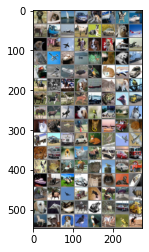

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

In [6]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [7]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Net().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [ ]:
net.train()

best_val_acc = 0
for epoch in range(10):
    for dataloader, training in zip([trainloader, valloader], [True, False]):
        epoch_loss, epoch_acc = [], []
        pbar = tqdm(dataloader)
        for data in pbar:
            pbar.set_description_str(f'Training {epoch}' if training else f'Validation {epoch}')
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = net(inputs)

            loss = criterion(outputs, labels)
            if training:
                loss.backward()
                optimizer.step()
              
            acc = ((torch.argmax(outputs, 1) == labels).sum().item() / labels.shape[0]) * 100

            epoch_acc.append(acc)
            epoch_loss.append(loss.item())
            pbar.set_postfix_str(f'Loss: {np.mean(epoch_loss)} Acc: {np.mean(epoch_acc)}')

        if not training and best_val_acc < np.mean(epoch_acc):
            torch.save(net.state_dict(), 'net.ckpt')
            best_vall_acc = np.mean(epoch_acc)
            
print('\nFinished Training')

In [ ]:
net = Net()
net.load_state_dict(torch.load('net.ckpt'))
net.to(device)
net.eval()

epoch_acc = []
for data in tqdm(testloader):
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
      outputs = net(inputs)      
    acc = ((torch.argmax(outputs, 1) == labels).sum().item() / labels.shape[0]) * 100
    epoch_acc.append(acc)
f'Test Acc: {np.mean(epoch_acc)}'

# PyTorch Lightning

In [8]:
%%capture
!pip install pytorch-lightning

In [9]:
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import pytorch_lightning as pl
import torchmetrics

In [10]:
class CIFARDataModule(pl.LightningDataModule):
    def __init__(self, batch_size=64, transform=None):
        super().__init__()
        self.batch_size = batch_size
        self.transform = transform

    def prepare_data(self):
        # download only
        CIFAR10(root='data', train=True, download=True)
        CIFAR10(root='data', train=False, download=True)

    def setup(self, stage):
        training_dataset = CIFAR10('data', train=True, download=False, transform=self.transform)
        test_dataset = CIFAR10('data', train=False, download=False, transform=self.transform)

        # train/val split
        train, val = random_split(training_dataset, [int(len(training_dataset) * 0.7), int(len(training_dataset) * 0.3)])

        # assign to use in dataloaders
        self.train_dataset = train
        self.val_dataset = val
        self.test_dataset = test_dataset

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

In [13]:
class Net(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        self.train_acc = torchmetrics.Accuracy()
        self.val_acc = torchmetrics.Accuracy()
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self.forward(inputs)

        loss = self.criterion(outputs, labels)          
        acc = self.train_acc(outputs, labels)
        self.log('train/loss', loss)
        self.log('train/accuracy', acc, prog_bar=True)
        return loss
    
    def training_epoch_end(self, training_step_outputs):
        training_acc = self.train_acc.compute()
        self.log('train/full_data_accuracy', training_acc)

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self.forward(inputs)

        loss = self.criterion(outputs, labels)
        acc = self.val_acc(outputs, labels)
        self.log('val/loss', loss)
        return loss

    def validation_epoch_end(self, val_step_outputs):
        val_acc = self.val_acc.compute()
        self.log('val/full_data_accuracy', val_acc)

In [14]:
model = Net()

transform = transforms.Compose([
      transforms.ToTensor(), 
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
cifar_dm = CIFARDataModule(transform=transform)

trainer = pl.Trainer(max_epochs=5, gpus=0)
trainer.fit(model, cifar_dm)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1585: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  "GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`."


Files already downloaded and verified
Files already downloaded and verified


Missing logger folder: /content/lightning_logs

  | Name      | Type             | Params
-----------------------------------------------
0 | conv1     | Conv2d           | 456   
1 | pool      | MaxPool2d        | 0     
2 | conv2     | Conv2d           | 2.4 K 
3 | fc1       | Linear           | 48.1 K
4 | fc2       | Linear           | 10.2 K
5 | fc3       | Linear           | 850   
6 | train_acc | Accuracy         | 0     
7 | val_acc   | Accuracy         | 0     
8 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
62.0 K    Trainable params
0         Non-trainable params
62.0 K    Total params
0.248     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:
trainer.test(test_dataloaders=cifar_dm.test_dataloader())

In [ ]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/